In [47]:
import heapq
import osmnx as ox
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from osmnx._errors import InsufficientResponseError
from smolagents import CodeAgent, LiteLLMModel, Tool, InferenceClientModel, FinalAnswerTool

In [19]:
print("Carregando o grafo de Belo Horizonte - MG...")
G = ox.graph.graph_from_place("belo horizonte - MG", network_type="walk")
#testar se o grafo está carregado
if G is not None:
    print("Grafo carregado com sucesso.")
else:
    print("Erro ao carregar o grafo.")

Carregando o grafo de Belo Horizonte - MG...
Grafo carregado com sucesso.


In [ ]:
# adiciona pontos de tourism
place = "Belo Horizonte, MG"
features = ox.features.features_from_place(place, {"tourism": True})

feature_points = features.representative_point()
nn = ox.distance.nearest_nodes(G, feature_points.x, feature_points.y)

for node, feature in zip(nn, features.to_dict(orient="records")):
    G.nodes[node].update({"tourism": feature})


In [21]:
print(f"Número de nós: {G.number_of_nodes()}")
print(f"Número de arestas: {G.number_of_edges()}")

Número de nós: 47394
Número de arestas: 139726


In [22]:
contagem = 0
for _, data in G.nodes(data=True):
    office = data.get("tourism")
    if isinstance(office, dict) :
        contagem += 1

print(f"Número de locais com a tag tourism: {contagem}")


Número de locais com a tag tourism: 183


In [23]:
place = "Belo Horizonte, MG"
features = ox.features.features_from_place(place, {"tourism": True})
print(features["tourism"].unique())

['artwork' 'motel' 'viewpoint' 'hotel' 'picnic_site' 'hostel'
 'information' 'museum' 'gallery' 'attraction' 'camp_site' 'yes' 'chalet'
 'apartment' 'guest_house' 'theme_park' 'zoo' 'park' 'aquarium']


In [ ]:
for node, data in G.nodes(data=True):
    tourism = data.get("tourism")
    if isinstance(tourism, dict):
        nome = tourism.get("name", "Desconhecido")
        print(f"- {nome}".strip())

- Mirante
- Lagoa da Pampulha
- Radisson Blu Belo Horizonte, Savassi
- Mirante Jardim Atlântico
- Museu de Arte da Pampulha
- Pampulha Flat
- Multimarkenting - Gráfica rápida
- Home Cen
- CAV Central de Atendimento ao Viajante
- Bristol
- Esfera Armilar
- Flamboyant Home Service
- Stop Inn Pampulha
- Campus Liberdade Flat
- Dayrell Hotel & Centro de Convenções
- Petites Buffet
- Sala de artes
- Hostel Mineirinho
- nan
- Horizonte Hotel
- Jardim Zoológico
- Obelisco da Praça 7 de Setembro
- Mirante do Mangabeiras
- ibis Belo Horizonte Savassi
- Centro Cultural Banco do Brasil BH
- Rio Jordao
- Museu da Imagem e do Som
- nan
- Allia Gran Hotel Pampulha Suites
- nan
- Hotel BH Residencial
- Edifício Maria Eduarda de Freitas
- Edifício Flor de Liz
- nan
- Wally's House Hostel
- nan
- Museu de Artes e Ofícios
- HI La em Casa Hostel
- Clube da Esquina
- Hostel BH
- Apart-Hotel Saint Martin
- nan
- Bristol Pampulha Lieu
- PRAÇA
- Golden Park
- casa Pri
- Hotel Ímpar - Suítes Expominas
- Parqu

In [59]:
def find_point(nome_local, tipo= "tourism"):
    place = f"{nome_local}, Belo Horizonte, MG"

    try:
        features = ox.features.features_from_place(place, {tipo: True})
        
        if features.empty:
            raise InsufficientResponseError("Nenhuma feature encontrada com essas tags.")

        feature_points = features.representative_point()
        nn = ox.distance.nearest_nodes(G, feature_points.x, feature_points.y)

        useful_tags = ["name", tipo, "addr:street", "addr:housenumber"]
        for node, feature in zip(nn, features[[col for col in useful_tags if col in features.columns]].to_dict(orient="records")):
            feature = {k: v for k, v in feature.items() if pd.notna(v)}
            G.nodes[node].update({tipo: feature})

        return nn[0]

    except (TypeError, InsufficientResponseError):
        # Fallback: localização pontual via geocodificação
        try:
            lat, lon = ox.geocode(place)
            node = ox.distance.nearest_nodes(G, lon, lat)
            G.nodes[node].update({tipo: {"name": nome_local}})
            return node
        except Exception as e:
            raise RuntimeError(f"It's not possible find the local {nome_local}': {e}")


In [26]:
# breadth-first search
def bfs(G, start, end):
    frontier = deque([(start, [], 0)])  # (nó atual, caminho até aqui, custo até aqui)
    explored = set()

    while frontier:
        node, path, cost = frontier.popleft()

        if node == end:
            return path + [node], cost

        if node in explored:
            continue
        explored.add(node)

        for neighbor in G.neighbors(node):
            if neighbor not in explored:
                frontier.append((neighbor, path + [node], cost + G[node][neighbor][0]["length"]))

    return None, 0


In [27]:
def astar(G, start, end):
    frontier = [(0, 0, start, [])]  # (f = g + h, g, node, path)
    explored = set()

    while frontier:
        f, cost, node, path = heapq.heappop(frontier)

        if node == end:
            return path + [node], cost

        if node in explored:
            continue

        explored.add(node)

        for neighbor in G.neighbors(node):
            if neighbor not in explored:
                try:
                    distancia = G[node][neighbor][0]["length"]
                except (KeyError, IndexError):
                    continue

                new_cost = cost + distancia
                heuristic = ox.distance.euclidean(
                    G.nodes[neighbor]["y"], G.nodes[neighbor]["x"],
                    G.nodes[end]["y"], G.nodes[end]["x"]
                )

                f = new_cost + heuristic
                heapq.heappush(frontier, (f, new_cost, neighbor, path + [node]))

    return None, 0


In [49]:
def plot_paths(caminho1, caminho2):
    # Plota o caminho principal (A*)
    fig, ax = ox.plot_graph_route(
        G, caminho1,
        route_color="blue",
        route_linewidth=4,
        node_size=0,
        show=False,
        close=False
    )

    # Plota o caminho alternativo (BFS)
    ox.plot_graph_route(
        G, caminho2,
        route_color="red",
        route_linewidth=2,
        node_size=0,
        ax=ax,
        show=False,
        close=False
    )

In [56]:
def find_route(origem_nome, destino_nome):
    origem = find_point(origem_nome)
    destino = find_point(destino_nome)

    pathAstar, costAstar = astar(G, origem, destino)
    pathBFS, costBFS = bfs(G, origem, destino)

    km1 = f"{costAstar / 1000:.1f}".replace(".", ",")
    km2 = f"{costBFS / 1000:.1f}".replace(".", ",")

    plot_paths(pathAstar, pathBFS)
    return f"The shortest path has cost = {km1}km, with {len(pathAstar)} nodes. An alternative path has cost = {km2}km, with {len(pathBFS)} nodes."

The shortest path has cost = 12,1km, with 144 nodes. An alternative path has cost = 14,2km, with 117 nodes.


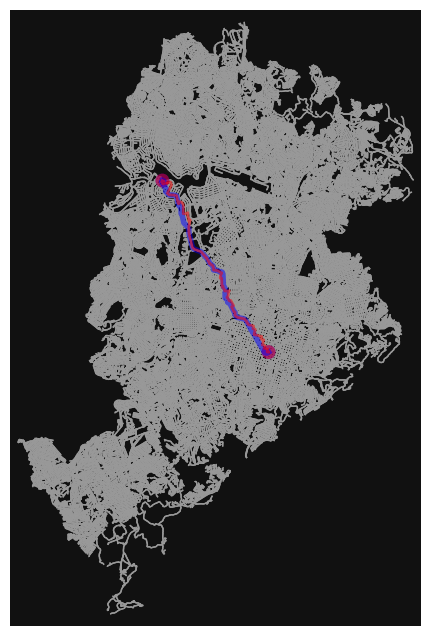

In [57]:
source = "Lagoa da Pampulha"
target = "Centro Cultural Banco do Brasil BH"
print(find_route(source, target))

The shortest path has cost = 1,5km, with 33 nodes. An alternative path has cost = 1,8km, with 23 nodes.


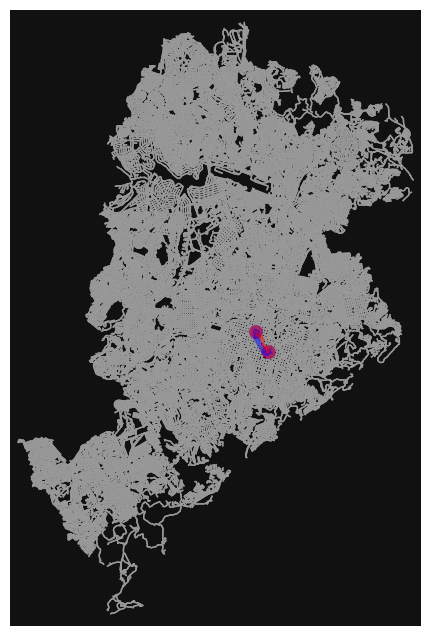

In [69]:
source = "Mercado Central"
target = "CCBB"
print(find_route(source, target))

The shortest path has cost = 7,6km, with 115 nodes. An alternative path has cost = 8,9km, with 87 nodes.


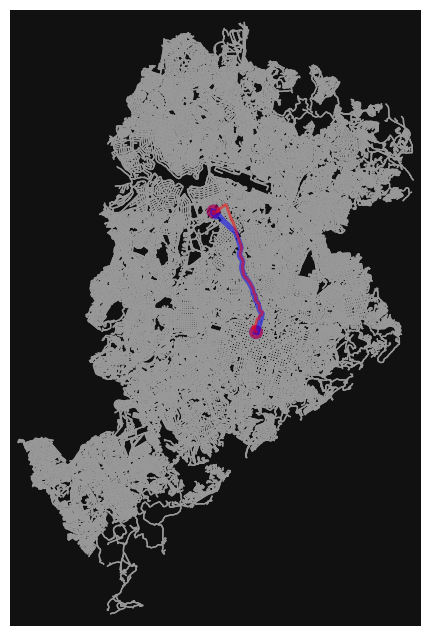

In [65]:
source = "Mercado Central"
target = "UFMG"
print(find_route(source, target))

In [74]:
class FindRouteTool(Tool):
    name = "find_route"
    description = """
    This tool must be used when you want to find the route or path between to places, locations or points.
    """
    inputs = {
        "source": {
            "type": "string",
            "description": "The source location. It can be an address, a place, a street name, etc."
        },
        "target": {
            "type": "string",
            "description": "The target location. It can be an address, a place, a street name, etc."
        }
    }
    output_type = "string"

    def forward(self, source, target):
        try:
            return find_route(source, target)
        except Exception as e:
            return f"It's not possible find a route from {source} to {target}."

In [75]:
model = LiteLLMModel(
    model_id="ollama/qwen3:latest",
    api_base="http://localhost:11434",
)

agent = CodeAgent(tools=[FindRouteTool()], model=model, add_base_tools=False)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Lagoa da Pampulha to Jardim Zoológico?                                                        │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Lagoa da Pampulha", target="Jardim Zoológico")                                        
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest path has cost = 4,0km, with 43 nodes. An alternative path has cost = 5,5km, with 
38 nodes.

[Step 1: Duration 51.60 seconds| Input tokens: 2,098 | Output tokens: 236]

'The shortest path has cost = 4,0km, with 43 nodes. An alternative path has cost = 5,5km, with 38 nodes.'

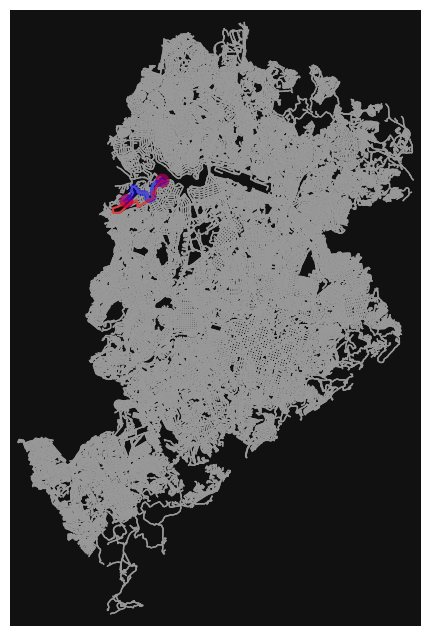

In [ ]:
agent.run("How can I go from Lagoa da Pampulha to Jardim Zoológico?")


In [63]:
agent.run("Qual o caminho entre a Lagoa da Pampulha e o Centro Cultural do Banco do Brasil BH?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Qual o caminho entre a Lagoa da Pampulha e o Centro Cultural do Banco do Brasil BH?                             │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Lagoa da Pampulha", target="Centro Cultural do Banco do Brasil BH")                   
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: It's not possible find a route from Lagoa da Pampulha to Centro Cultural do Banco do Brasil BH.

[Step 1: Duration 78.51 seconds| Input tokens: 2,100 | Output tokens: 394]

"It's not possible find a route from Lagoa da Pampulha to Centro Cultural do Banco do Brasil BH."

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Qual o caminho entre a Lagoa da Pampulha e o CCBB                                                               │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Lagoa da Pampulha", target="CCBB")                                                    
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest path has cost = 12,1km, with 144 nodes. An alternative path has cost = 14,2km, 
with 117 nodes.

[Step 1: Duration 68.16 seconds| Input tokens: 2,095 | Output tokens: 293]

'The shortest path has cost = 12,1km, with 144 nodes. An alternative path has cost = 14,2km, with 117 nodes.'

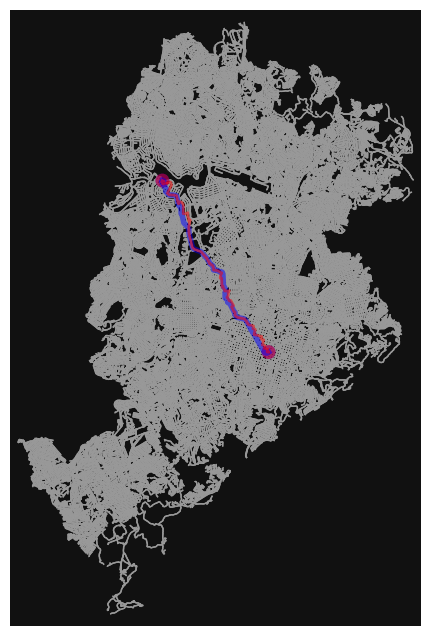

In [61]:
agent.run("Qual o caminho entre a Lagoa da Pampulha e o CCBB")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Mercado Central to Mercado Central?                                                           │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Mercado Central", target="Mercado Central")                                           
  print(route)                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
The shortest path has cost = 0,0km, with 1 nodes. An alternative path has cost = 0,0km, with 1 nodes.

Out: None

[Step 1: Duration 113.09 seconds| Input tokens: 2,089 | Output tokens: 273]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("You are already at Mercado Central.")                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: You are already at Mercado Central.

[Step 2: Duration 32.90 seconds| Input tokens: 4,561 | Output tokens: 388]

'You are already at Mercado Central.'

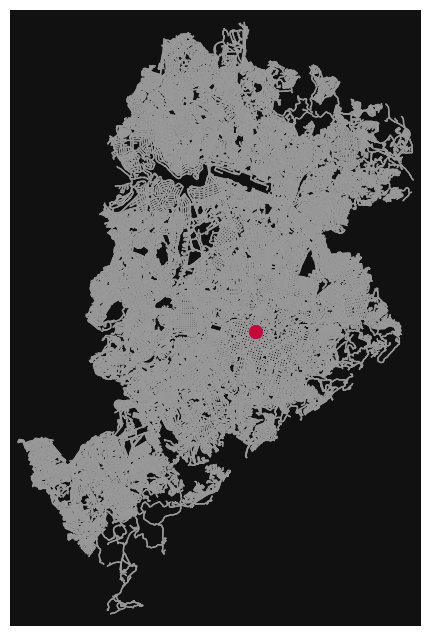

In [73]:
agent.run("How can I go from Mercado Central to Mercado Central?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Mercado Central to UFMG?                                                                      │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Mercado Central", target="UFMG")                                                      
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest path has cost = 7,6km, with 115 nodes. An alternative path has cost = 8,9km, with 
87 nodes.

[Step 1: Duration 59.53 seconds| Input tokens: 2,089 | Output tokens: 238]

'The shortest path has cost = 7,6km, with 115 nodes. An alternative path has cost = 8,9km, with 87 nodes.'

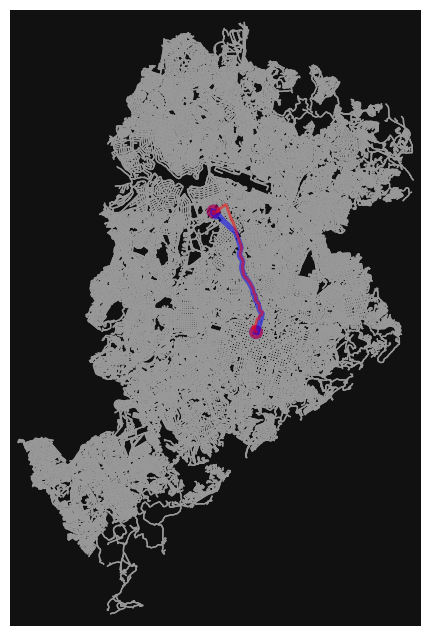

In [64]:
agent.run("How can I go from Mercado Central to UFMG?")

In [70]:
agent.run("Como eu posso ir do Parque Ibirapuera até o Jardim Zoológico?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Como eu posso ir do Parque Ibirapuera até o Jardim Zoológico?                                                   │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Parque Ibirapuera", target="Jardim Zoológico")                                        
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: It's not possible find a route from Parque Ibirapuera to Jardim Zoológico.

[Step 1: Duration 80.40 seconds| Input tokens: 2,099 | Output tokens: 178]

"It's not possible find a route from Parque Ibirapuera to Jardim Zoológico."

In [71]:
agent.run("Qual a diferença entre os cursos de Ciência da Computação e Sistemas de Informação?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Qual a diferença entre os cursos de Ciência da Computação e Sistemas de Informação?                             │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Computer Science focuses on the theoretical foundations and technical aspects of computing, such   
  as algorithms, data structures, and programming. Information Systems, on the other hand, emphasizes the          
  application of technology in business and organizational contexts, covering topics like database management,     
  information systems design, and project management. While both fields overlap in some areas, Computer Science    
  is more technical, and Information Systems is more business-oriented.")                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Computer Science focuses on the theoretical foundations and technical aspects of computing, 
such as algorithms, data structures, and programming. Information Systems, on the other hand, emphasizes the 
application of technology in business and organizational contexts, covering topics like database management, 
information systems design, and project management. While both fields overlap in some areas, Computer Science is 
more technical, and Information Systems is more business-oriented.

[Step 1: Duration 169.01 seconds| Input tokens: 2,096 | Output tokens: 883]

'Computer Science focuses on the theoretical foundations and technical aspects of computing, such as algorithms, data structures, and programming. Information Systems, on the other hand, emphasizes the application of technology in business and organizational contexts, covering topics like database management, information systems design, and project management. While both fields overlap in some areas, Computer Science is more technical, and Information Systems is more business-oriented.'

In [72]:
agent.run("Como posso ir de Ciência da Computação para Sistemas de Informação?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Como posso ir de Ciência da Computação para Sistemas de Informação?                                             │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:latest ────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Ciência da Computação", target="Sistemas de Informação")                              
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: It's not possible find a route from Ciência da Computação to Sistemas de Informação.

[Step 1: Duration 155.34 seconds| Input tokens: 2,094 | Output tokens: 711]

"It's not possible find a route from Ciência da Computação to Sistemas de Informação."